Install dependencies

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Check for CUDA

In [ ]:
import torch
torch.cuda.is_available()

True

Load model

In [ ]:
import os
os.environ['CUDA_AVAILABLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloom-1b7",
    torch_dtype = torch.float16,
    device_map = 'auto'
)

tokenizer = AutoTokenizer.from_pretrained("bigscience/tokenizer")

In [ ]:
print(model)

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 2048)
    (word_embeddings_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (

##Note  we will focus on query_key_value submodule

In [ ]:
def Print_number_of_trainable_parameters(model) :
  trainable_model_params = all_model_params = 0

  for _, param in model.named_parameters() :
    all_model_params += param.numel()
    if param.requires_grad :
      trainable_model_params += param.numel()

  return f"trainable model parameters : {trainable_model_params} \nall model parameters : {all_model_params}\npercentage of trainable model parameters : {100 * trainable_model_params / all_model_params:.2f}%"

print(Print_number_of_trainable_parameters(model))

trainable model parameters : 1722408960 
all model parameters : 1722408960
percentage of trainable model parameters : 100.00%


Configuring LoRA

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8, # rank of the low matrices
    lora_alpha = 16, # scaling factor
    target_modules=['query_key_value'], # parameters to be finetuned
    lora_dropout = 0.05, # for regularization
    bias = 'none', # whether to train bias params or not
    task_type = 'CAUSAL_LM' # task of the model
)

model = get_peft_model(model, config)
Print_number_of_trainable_parameters(model)

'trainable model parameters : 1572864 \nall model parameters : 1723981824\npercentage of trainable model parameters : 0.09%'

Notice that the number of trainable parameters has reduced to less that 10%

Loading data set

In [ ]:
from datasets import load_dataset

qa_dataset = load_dataset('squad_v2')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [ ]:
qa_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

Prompt template

```
### CONTEXT
{context}

### QUESTION
{question}

### ANSWER
{answer}
```

In [ ]:
def create_prompt(context, question, answer) :
  if len(answer['text']) < 1 :
    answer = 'Can not find answer'
  else :
    answer = answer['text'][0]

  prompt_template = f"### CONTEXT\n{context}\n\n### QUESTION\n{question}\n\n### ANSWER\n{answer}</s>"
  return prompt_template

mapped_qa_dataset = qa_dataset.map(lambda samples: tokenizer(create_prompt(samples['context'], samples['question'], samples['answers'])))

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Training

In [ ]:
import transformers
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'outputs',
    learning_rate = 1e-5,
    num_train_epochs = 1,
    weight_decay = 0.01,
    logging_steps=1,
    max_steps = 100,
    per_device_train_batch_size=4
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = mapped_qa_dataset['train'],
    eval_dataset = mapped_qa_dataset['validation'],
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cashe = False

In [ ]:
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,3.041000
2,2.966800
3,2.888700
4,3.226600
5,2.878900
6,2.908200
7,2.955100
8,3.179700
9,3.191400
10,2.884800


TrainOutput(global_step=100, training_loss=3.0237109375, metrics={'train_runtime': 64.7178, 'train_samples_per_second': 6.181, 'train_steps_per_second': 1.545, 'total_flos': 751085857013760.0, 'train_loss': 3.0237109375, 'epoch': 0.0})

Pushing to hub

In [ ]:
HUGGING_FACE_USER_NAME = 'AhmedElDokmak'

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_name = "Bloom1B7finetuning"

model.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)

adapter_model.bin:   0%|          | 0.00/6.31M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AhmedElDokmak/Bloom1B7finetuning/commit/62c92ecaa46e9d8e55b2f097a73fe4b9b3e49f98', commit_message='Upload model', commit_description='', oid='62c92ecaa46e9d8e55b2f097a73fe4b9b3e49f98', pr_url=None, pr_revision=None, pr_num=None)

Loading and testing the model

In [3]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

HUGGING_FACE_USER_NAME = 'AhmedElDokmak'
model_name = "Bloom1B7finetuning"
peft_model_id = f"{HUGGING_FACE_USER_NAME}/{model_name}"

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=False, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
qa_model = PeftModel.from_pretrained(model, peft_model_id)

Some weights of BloomForCausalLM were not initialized from the model checkpoint at bigscience/bloom-1b7 and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.6 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, Markdown

def make_inference(context, question):
  batch = tokenizer(f"### CONTEXT\n{context}\n\n### QUESTION\n{question}\n\n### ANSWER\n", return_tensors = 'pt')

  with torch.cuda.amp.autocast():
    output_tokens = qa_model.generate(**batch.to('cuda'), max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [ ]:
context = "Cheese is the best food."
question = "What is the best food?"

make_inference(context, question)

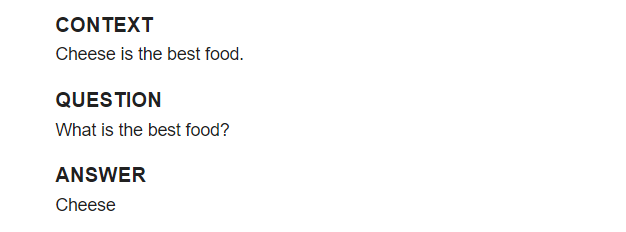

In [7]:
context = "Cheese is the best food."
question = "How far away is the Moon from the Earth?"

make_inference(context, question)

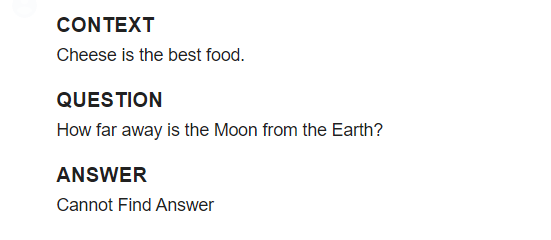

In [8]:
context = "The Moon orbits Earth at an average distance of 384,400 km (238,900 mi), or about 30 times Earth's diameter. Its gravitational influence is the main driver of Earth's tides and very slowly lengthens Earth's day. The Moon's orbit around Earth has a sidereal period of 27.3 days. During each synodic period of 29.5 days, the amount of visible surface illuminated by the Sun varies from none up to 100%, resulting in lunar phases that form the basis for the months of a lunar calendar. The Moon is tidally locked to Earth, which means that the length of a full rotation of the Moon on its own axis causes its same side (the near side) to always face Earth, and the somewhat longer lunar day is the same as the synodic period. However, 59% of the total lunar surface can be seen from Earth through cyclical shifts in perspective known as libration."
question = "At what distance does the Moon orbit the Earth?"

make_inference(context, question)

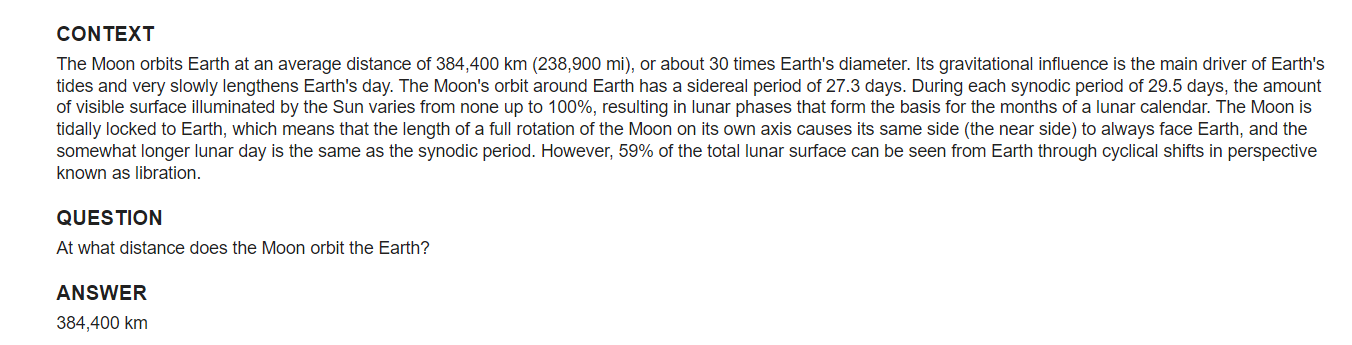